In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
from IPython.display import display

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [2]:
from itertools import combinations

measures = ['ratio_selection_rate', 'ratio_recall', 'ratio_odds']

def multicriteria(measurement_values):
    pairs = list(combinations(measurement_values, 2))
    area = 0
    for a, b in pairs:
        area += (a*b*math.sin((2*math.pi)/3)/2)    
    return area

def multicriteria_validation(validation):
    matrix = validation[measures].to_numpy()
    validation['multicriteria'] = [multicriteria(row) for row in matrix]
    return validation

In [3]:
def report(measure):

    results_valid = pd.DataFrame(columns = ['Dataset', 'Config', 'Without', 'DIF-SR(CART)', 'DIF-SR(KNN)',
                                            'DIF-SR(MLP)', 'Reweighing'])
    results_test = pd.DataFrame(columns = ['Dataset', 'Config',  'Without', 'DIF-SR(CART)', 'DIF-SR(KNN)',
                                            'DIF-SR(MLP)', 'Reweighing'])
    f1 = pd.DataFrame(columns = ['Dataset', 'Config',  'Without', 'DIF-SR(CART)', 'DIF-SR(KNN)',
                                 'DIF-SR(MLP)', 'Reweighing'])
    count = 0

    for name in ['adult', 'arrhythmia', 'bank', 'compasmen', 'compaswomen', 'contraceptive', 'crack', 
                 'german', 'heart', 'heroin', 'student', 'titanic']:
        for config in ['ada', 'dt', 'rf', 'svm', 'xgb']:
            ''' abre os resultados '''
            if os.path.exists('../Experiments/' + name + '_' + config + '_validation.csv'):
                validation = pd.read_csv('../Experiments/' + name + '_' + config + '_validation.csv', 
                                         sep=';', index_col=0) 
                test = pd.read_csv('../Experiments/' + name + '_' + config + '_test.csv', 
                                   sep=';', index_col=0)
                ''' Calculate ratio odds '''
                validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
                test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2
                ''' Calculate multicriteria '''
                validation = multicriteria_validation(validation)
                test = multicriteria_validation(test)

                values_valid = []
                values_valid.append(name)
                values_valid.append(config)

                values_test = []
                values_test.append(name)
                values_test.append(config)
                
                values_f1 = []
                values_f1.append(name)
                values_f1.append(config)

                for preprocessing in ['without', 'dif_dt', 'dif_knn', 'dif_mlp', 'reweighing']:

                    aux_validation = validation.loc[validation['preprocessing'] == preprocessing].copy()
                    aux_validation = aux_validation.sort_values(by=['clf_name'])
                    aux_validation = aux_validation.reset_index()

                    aux_test = test.loc[test['preprocessing'] == preprocessing].copy()
                    aux_test = aux_test.sort_values(by=['clf_name'])
                    aux_test = aux_test.reset_index()

                    idx = aux_validation[measure].idxmax()
                    values_valid.append(aux_validation.loc[idx, measure])
                    values_test.append(aux_test.loc[idx, measure])
                    values_f1.append(aux_test.loc[idx, 'f1_macro'])
                    
                
                results_valid.loc[count] = values_valid
                results_test.loc[count] = values_test
                f1.loc[count] = values_f1
                count += 1
                
    return results_valid, results_test, f1

In [6]:
def cd(results, conjunto):
    df = results[['Without', 'DIF-SR(CART)', 'DIF-SR(KNN)', 'DIF-SR(MLP)', 'Reweighing']]
    algorithms_names = df.columns
    results_array = df.values

    ranks_test = np.array([rankdata(-p) for p in results_array])
    average_ranks = np.mean(ranks_test, axis=0)
    print('\n'.join('({}) Rank average: {}'.format(a, r) for a, r in zip(algorithms_names, average_ranks)))
    
    # This method computes the critical difference for Nemenyi test
    cd = compute_CD(average_ranks, n=len(df), alpha='0.05', test='nemenyi')
    print('CD = ', cd)
    # This method generates the plot.
    graph_ranks(average_ranks, names=algorithms_names, cd=cd, width=4, textspace=1.25, reverse=False, 
                filename = conjunto + '.pdf')

## Multicriteria (Demographic Parity, Equal Opportunity, Equalized Odds)

In [7]:
validation, test, f1 = report('multicriteria')
#mostrar por algoritmo pro antonio
test.groupby(by='Dataset').mean().round(decimals=2)

/tmp/ipykernel_43725/2091123629.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test.groupby(by='Dataset').mean().round(decimals=2)


,Without,DIF-SR(CART),DIF-SR(KNN),DIF-SR(MLP),Reweighing
Dataset,,,,,
adult,0.39,0.50,0.58,0.59,0.49
arrhythmia,0.71,0.53,1.02,0.62,0.87
bank,0.58,0.59,0.63,0.66,0.75
compasmen,0.77,1.14,1.17,1.12,0.83
compaswomen,0.89,1.16,1.09,1.00,0.88
contraceptive,1.11,1.00,0.79,0.79,1.12
crack,0.45,0.46,0.36,0.81,0.05
german,0.89,0.94,0.66,0.89,0.97
heart,0.51,0.62,0.67,0.75,0.55


In [8]:
test.groupby(by='Dataset').std().round(decimals=2)

/tmp/ipykernel_43725/238434877.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test.groupby(by='Dataset').std().round(decimals=2)


,Without,DIF-SR(CART),DIF-SR(KNN),DIF-SR(MLP),Reweighing
Dataset,,,,,
adult,0.03,0.11,0.11,0.08,0.06
arrhythmia,0.07,0.32,0.24,0.11,0.12
bank,0.06,0.12,0.09,0.15,0.08
compasmen,0.09,0.08,0.14,0.13,0.11
compaswomen,0.44,0.10,0.13,0.16,0.33
contraceptive,0.07,0.20,0.42,0.45,0.04
crack,0.51,0.42,0.42,0.49,0.06
german,0.23,0.21,0.37,0.25,0.20
heart,0.22,0.38,0.27,0.33,0.04


In [9]:
test.mean().round(decimals=2)

/tmp/ipykernel_43725/3210981437.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.mean().round(decimals=2)


Without         0.65
DIF-SR(CART)    0.75
DIF-SR(KNN)     0.76
DIF-SR(MLP)     0.78
Reweighing      0.68
dtype: float64

In [10]:
test.std().round(decimals=2)

/tmp/ipykernel_43725/492759199.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.std().round(decimals=2)


Without         0.36
DIF-SR(CART)    0.37
DIF-SR(KNN)     0.37
DIF-SR(MLP)     0.32
Reweighing      0.36
dtype: float64

/tmp/ipykernel_43725/1082393728.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cd(validation.groupby(by='Dataset').mean(), 'cd_av_multicriteria_validation')


(Without) Rank average: 4.166666666666667
(DIF-SR(CART)) Rank average: 2.75
(DIF-SR(KNN)) Rank average: 2.4166666666666665
(DIF-SR(MLP)) Rank average: 2.4166666666666665
(Reweighing) Rank average: 3.25
CD =  1.7607705457029317


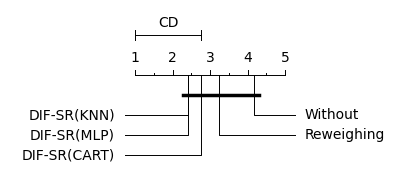

In [11]:
cd(validation.groupby(by='Dataset').mean(), 'cd_av_multicriteria_validation')

(Without) Rank average: 4.0
(DIF-SR(CART)) Rank average: 2.75
(DIF-SR(KNN)) Rank average: 2.5
(DIF-SR(MLP)) Rank average: 2.5833333333333335
(Reweighing) Rank average: 3.1666666666666665
CD =  1.7607705457029317


/tmp/ipykernel_43725/3509805831.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cd(test.groupby(by='Dataset').mean(), 'cd_av_multicriteria_test')


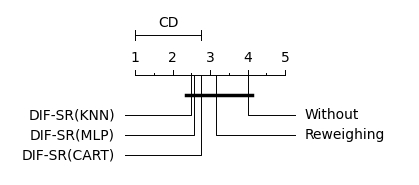

In [12]:
cd(test.groupby(by='Dataset').mean(), 'cd_av_multicriteria_test')